In [1]:
import numpy as np
import mpmath as mp
import renormalization as rg
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
mp.mp.dps = 30
mp.mp.pretty = False

# Transfer matrix for spin-s Ising model

In [3]:
s = .5

T = 1
t = rg.transfer_matrix(s, 1/T)
print(t)

[                             1.0  0.135335283236612691893999494972]
[0.135335283236612691893999494972                               1.0]


# Renormalization group flow

In [6]:
s = 0.5 # Spin number s
T = .1 # Temperature 1/J

p = 0.5 # Antiferromagnetic bond concentration
N = 500 # Bond population
n = 500 # RG iteration number

# Ferro and antiferro transfer matrices
ferro  = rg.transfer_matrix(s,  1/T)
aferro = rg.transfer_matrix(s, -1/T)

t_list = []
for _ in range(int((1 - p) * N)):
    t_list.append(ferro)
for _ in range(int(p * N)):
    t_list.append(aferro)

ij = 19
j = rg.element_ratio(t_list[ij])
X = rg.element_ratio(t_list[ij]) / rg.average_element_ratio_strength(t_list)

print("k    J(ij) / <|J|>      J(ij) \n")
print(0, "   ", X, "             ", j)

flow = [[0, X]]
for k in range(1, n):
    
    t_list = rg.renormalize(N, t_list)
    
    j = rg.element_ratio(t_list[ij])
    j_absavr = rg.average_element_ratio_strength(t_list)
    X = j / j_absavr
    flow.append([k, X])
    print(k, "   ", X, "    ", j)
    
flow = np.array(flow)

k    J(ij) / <|J|>      J(ij) 

0     1.0               10.0
1     2.36537467269393721330547241797      29.9999999999999999957516457447
2     1.72112689638386145158290749343      29.7972674459459178037005506232
3     0.309828697351472243611128717637      7.1429086253630048412199021727
4     -0.092535967293846157941996976618      -2.68133678618889123862719323392
5     -2.34186326692568400475781819387      -86.7905800055445938874404445735
6     -1.36488142299893609173467474496      -64.1239325491698464858904141888
7     -0.186497549107979977915926802452      -11.1469685038087354096098569239
8     0.33091616815064278160597928469      25.9581389871380172236329107311
9     1.13668604157650611479045146379      116.296696431588852326391215456
10     -1.65439127803836543710099896206      -228.01331930931231713286511029
11     -1.26677592784090862832788054616      -219.741747449339426791606377184
12     -0.940461717461996855396987914668      -194.569957546954886945887841927
13     0.51503901197

## RG trajectory plot

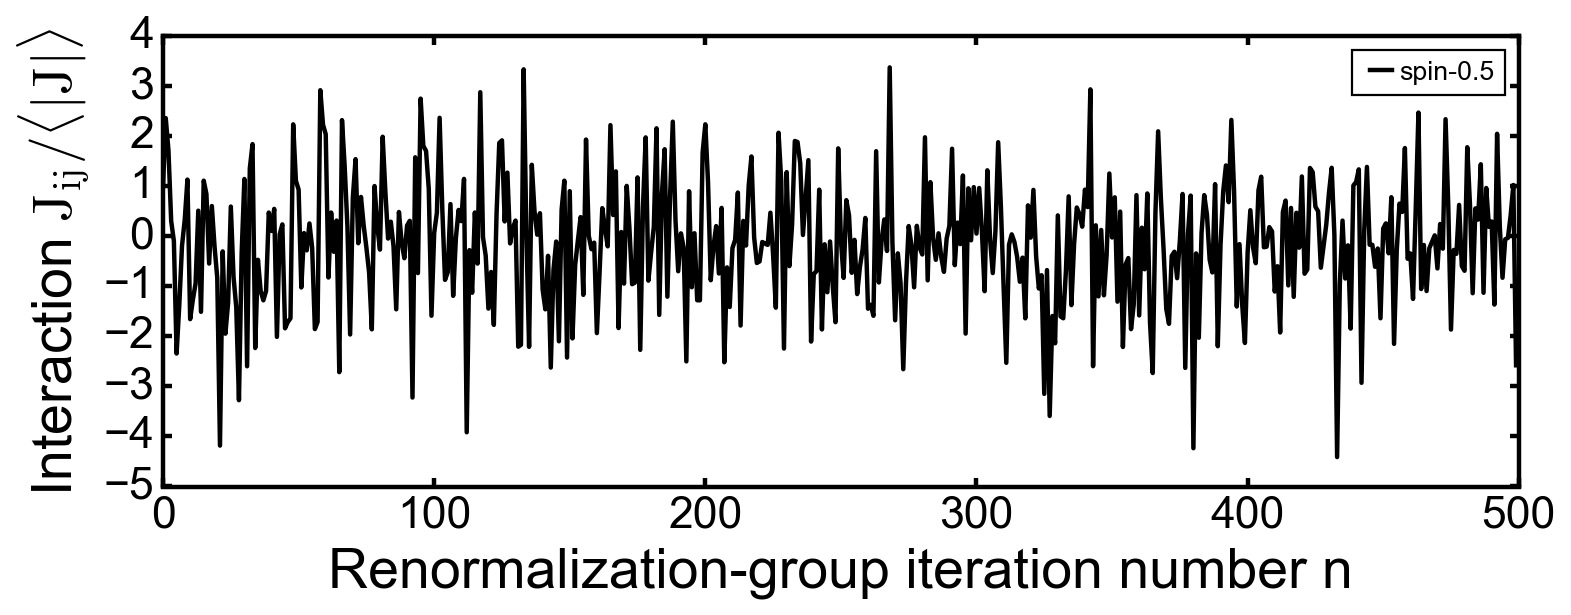

In [9]:
lw = 2
fs = 20
fig = plt.figure(figsize=(10, 4))
fig.set_facecolor('none')
plt.style.use('classic')
plt.rc('lines', linewidth=lw)
plt.rc('axes', linewidth=lw)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

ax = plt.subplot(111)
ax.plot(flow[:,0], flow[:,1], linestyle='-', marker='', markersize=10, label="spin-" + str(s), color='black')

ax.legend(loc='upper right', ncol=1, prop={'size':fs - 8}, labelspacing=0.5, handlelength=1.4, handletextpad=0)
ax.tick_params(axis="both", direction="in", left=True, width=lw, length=4, labelsize=fs)
ax.set_xlabel(r"Renormalization-group iteration number n", fontsize=fs)
ax.set_ylabel(r"Interaction $\mathrm{J_{ij} / \langle |J| \rangle}$", fontsize=fs)
plt.tight_layout()
plt.show()
#fig.savefig('chaotic_flow', bbox_inches="tight")

In [26]:
s = 0.5 # Spin number s
T = 0.5 # Temperature 1/J

p = 0.5 # Antiferromagnetic bond concentration
N = 500 # Bond population
n = 10 # RG iteration number

# Ferro and antiferro transfer matrices
ferro  = rg.transfer_matrix(s,  1/T)
aferro = rg.transfer_matrix(s, -1/T)

t_list = []
for _ in range(int((1 - p) * N)):
    t_list.append(ferro)
for _ in range(int(p * N)):
    t_list.append(aferro)

ij = 19
j = rg.element_ratio(t_list[ij])
X = rg.element_ratio(t_list[ij]) / rg.average_element_ratio_strength(t_list)

print(f"""
Spin number s = {s}
Temparature 1/J = {T}
Bond population N = {N}
Antiferromagnetic bond concentration p = {p}
=============================================
""")
print("k     λ         X")
print("_________________")
print(f"{0}     {mp.nan}      {X}")

flow = [[0, X]]
lyapunov_list = [[0, mp.nan]]

eps = 0.0001

for k in range(1, n):
    
    t_list_ = rg.renormalize(N, t_list)

    # Averages: <|J|> and <|J'|>
    j_avr  = rg.average_element_ratio_strength(t_list)
    j_avr_ = rg.average_element_ratio_strength(t_list_)

    # Deviation to J
    delta = eps * j_avr
    te = rg.transfer_matrix(s, delta)

    # Deviated t_list
    deviated_t_list = []
    for i in range(len(t_list)):
        te = rg.mp_multiply(t_list[i], te)
        deviated_t_list.append(te)

    # Renormalize deviated transfer matrix list
    deviated_t_list_ = rg.renormalize(N, deviated_t_list)

    # Derivation: dX(k+1)/dX(k), X(k):=J(ij)/<|J|>
    j_ = rg.element_ratio(t_list_[ij])
    dj_ = rg.element_ratio(deviated_t_list_[ij])
    j_delta = np.absolute(j_ - dj_)
    derivative = (j_delta / delta) * (j_avr / j_avr_)

    # Log of derivative
    if derivative == 0.0 or mp.isnan(derivative):
        ly = mp.nan
        lyapunov_list.append([k, ly])
        
    else:
        ly = mp.log(derivative)
        lyapunov_list.append([k, ly])
    
    j_absavr_ = rg.average_element_ratio_strength(t_list_)
    X = j_ / j_absavr_
    flow.append([k, X])

    print(f"{k}     {mp.nstr(ly, 5)}     {mp.nstr(X, 5)}")

    # Recover the renormalized list
    t_list = t_list_


Spin number s = 0.5
Temparature 1/J = 0.5
Bond population N = 500
Antiferromagnetic bond concentration p = 0.5

k     λ         X
_________________
0     nan      1.0
1     16.151     0.62651
2     13.749     1.2484
3     14.146     0.20243
4     13.306     1.6938
5     13.269     0.22868
6     12.26     -0.72793
7     13.815     -0.57654
8     13.879     -1.2131
9     14.22     -2.6449


/Users/artun/anaconda3/envs/phase-transitions/lib/python3.12/site-packages/matplotlib/cbook.py:1345: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


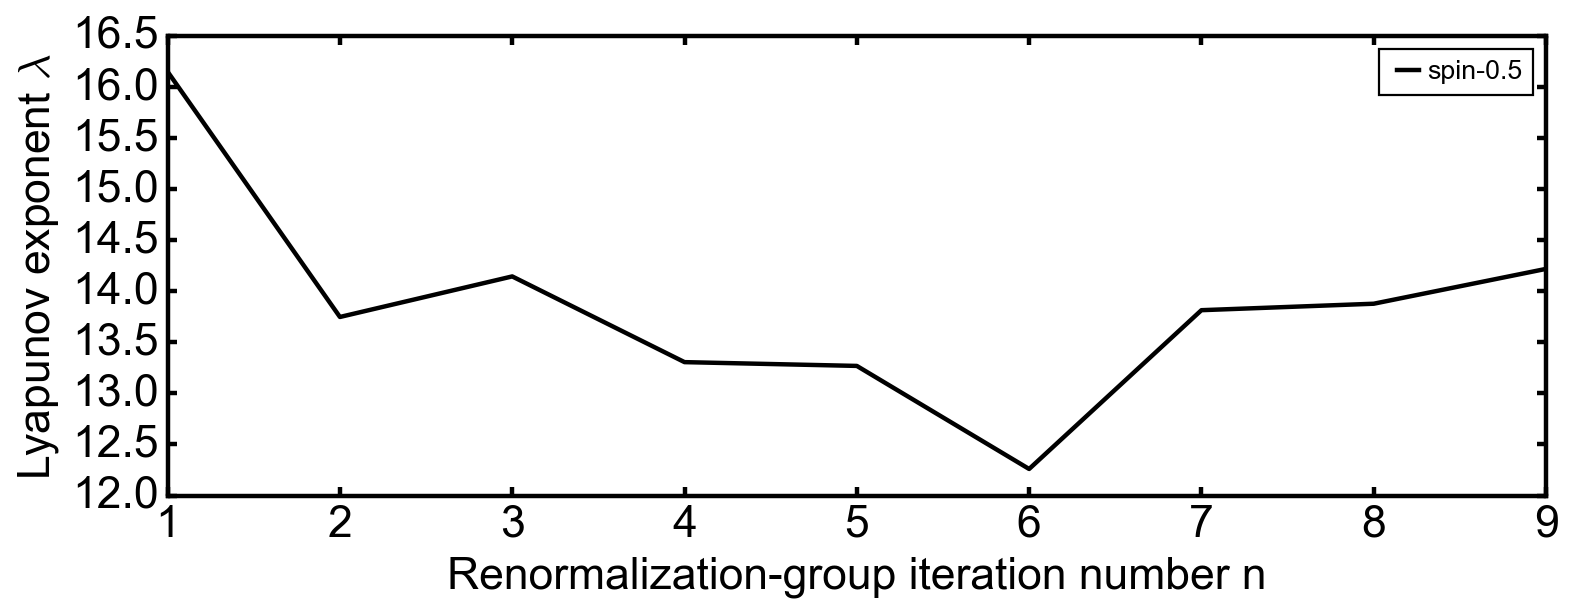

In [33]:
lyapunov_list = np.array(lyapunov_list)

lw = 2
fs = 20
fig = plt.figure(figsize=(10, 4), layout='tight')
fig.set_facecolor('none')
plt.style.use('classic')
plt.rc('lines', linewidth=lw)
plt.rc('axes', linewidth=lw)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

ax = plt.subplot(111)
ax.plot(lyapunov_list[:,0], lyapunov_list[:,1], linestyle='-', marker='', markersize=10, label="spin-" + str(s), color='black')
ax.legend(loc='upper right', ncol=1, prop={'size':fs - 8}, labelspacing=0.5, handlelength=1.4, handletextpad=0)
ax.tick_params(axis="both", direction="in", left=True, width=lw, length=4, labelsize=fs)
ax.set_xlabel(r"Renormalization-group iteration number n", fontsize=fs)
ax.set_ylabel(r"Lyapunov exponent $\mathrm{\lambda}$", fontsize=fs)
plt.show()
#fig.savefig('chaotic_flow', bbox_inches="tight")

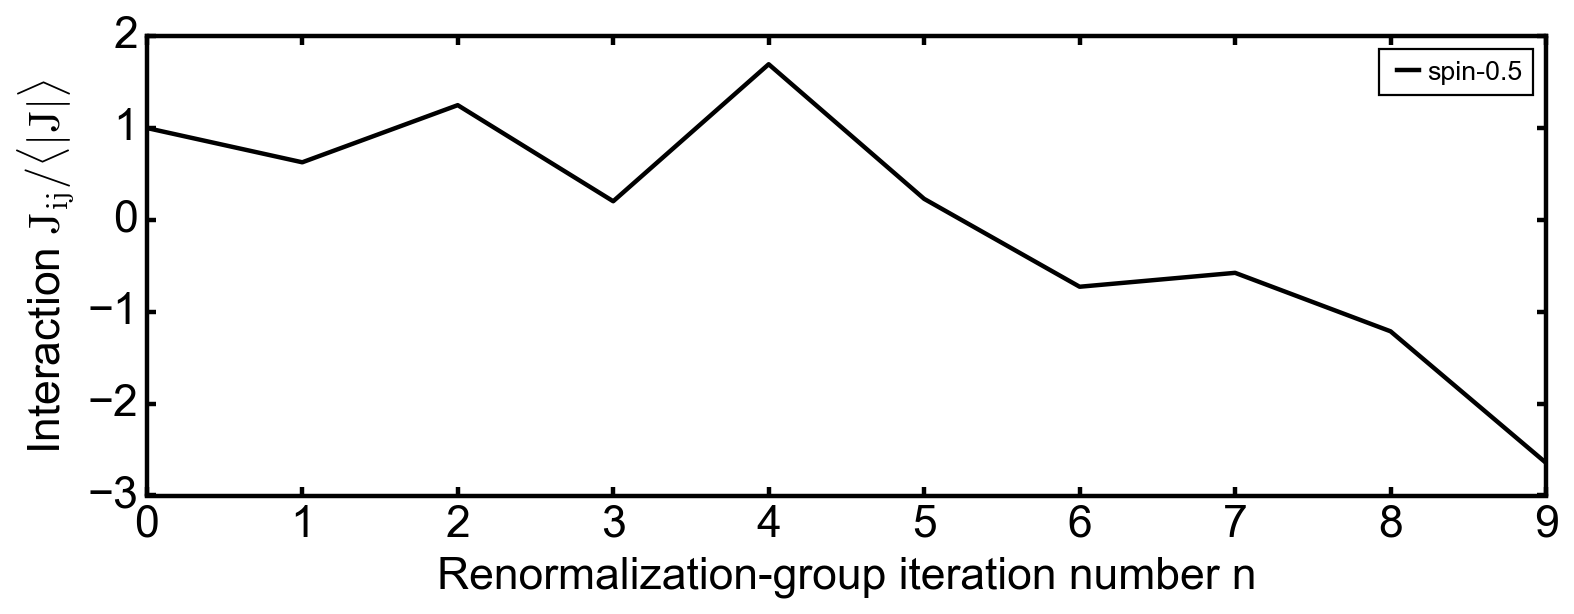

In [34]:
flow = np.array(flow)

lw = 2
fs = 20
fig = plt.figure(figsize=(10, 4), layout='tight')
fig.set_facecolor('none')
plt.style.use('classic')
plt.rc('lines', linewidth=lw)
plt.rc('axes', linewidth=lw)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

ax = plt.subplot(111)
ax.plot(flow[:,0], flow[:,1], linestyle='-', marker='', markersize=10, label="spin-" + str(s), color='black')
ax.legend(loc='upper right', ncol=1, prop={'size':fs - 8}, labelspacing=0.5, handlelength=1.4, handletextpad=0)
ax.tick_params(axis="both", direction="in", left=True, width=lw, length=4, labelsize=fs)
ax.set_xlabel(r"Renormalization-group iteration number n", fontsize=fs)
ax.set_ylabel(r"Interaction $\mathrm{J_{ij} / \langle |J| \rangle}$", fontsize=fs)
plt.show()
#fig.savefig('chaotic_flow', bbox_inches="tight")